## 1. **Introduction and Summary of the Findings**

### **1.1 Project Objective**
Building on previous work classifying boss fights based on keystroke patterns, this project pivots to a more ambitious goal: Behavioral Cloning. The objective is to train an autonomous agent to play Cuphead by imitating human gameplay.

I selected The Root Pack (Botanic Panic) boss fight for this experiment, as its distinct projectiles and stationary enemies provide an ideal environment for testing spatial reasoning and reaction times.

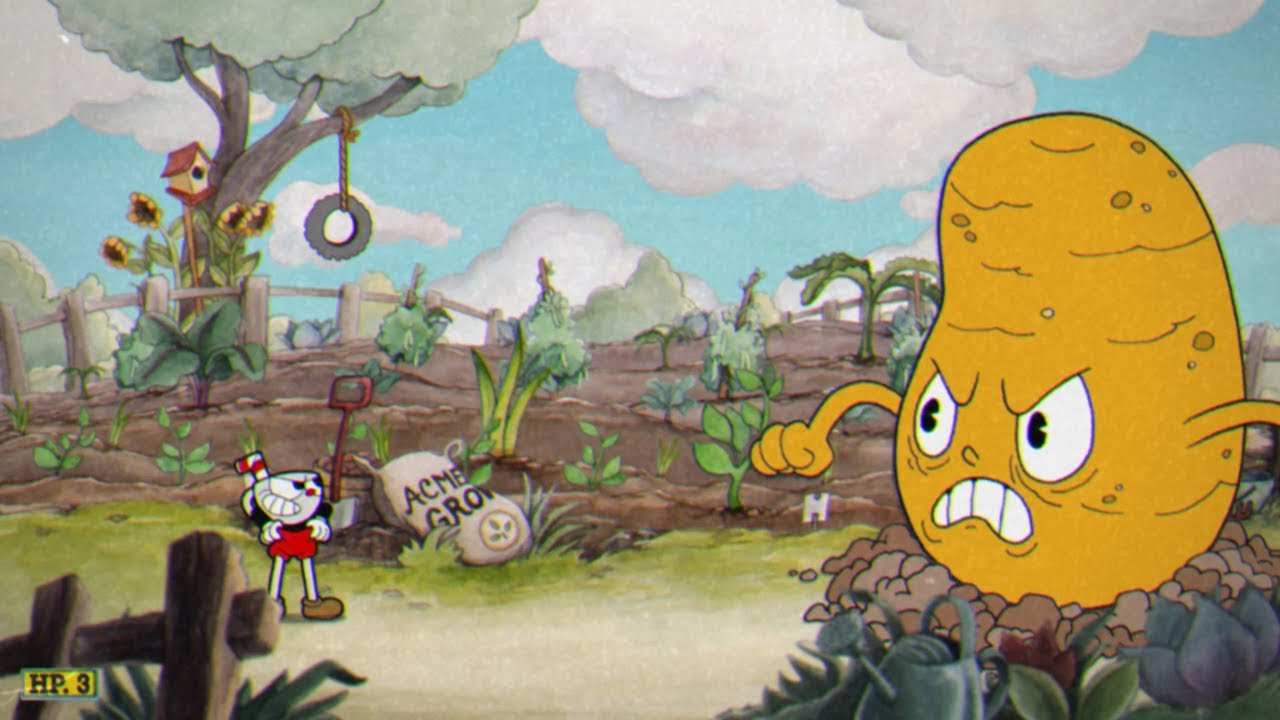

The core challenge was that the agent must learn to extract spatial features (e.g., where the projectile is) and infer temporal dynamics (velocity and trajectory) solely from a sequence of grayscale images, without access to internal game variables.

### **1.2 Core Problem**

Before training, I analyzed the distribution of actions in the dataset (see Appendix B for the code). This revealed a critical obstacle: Extreme Class Imbalance.

In Cuphead, the player holds the 'Shoot' button almost constantly, while special keys like 'Jump' and 'Dash' are executed only in split-second reaction to threats. As shown in Figure 1, the 'Shoot' action is active in 55.8% of frames, while 'Jump' appears in only 2.9% and 'Dash' in 0.7%.

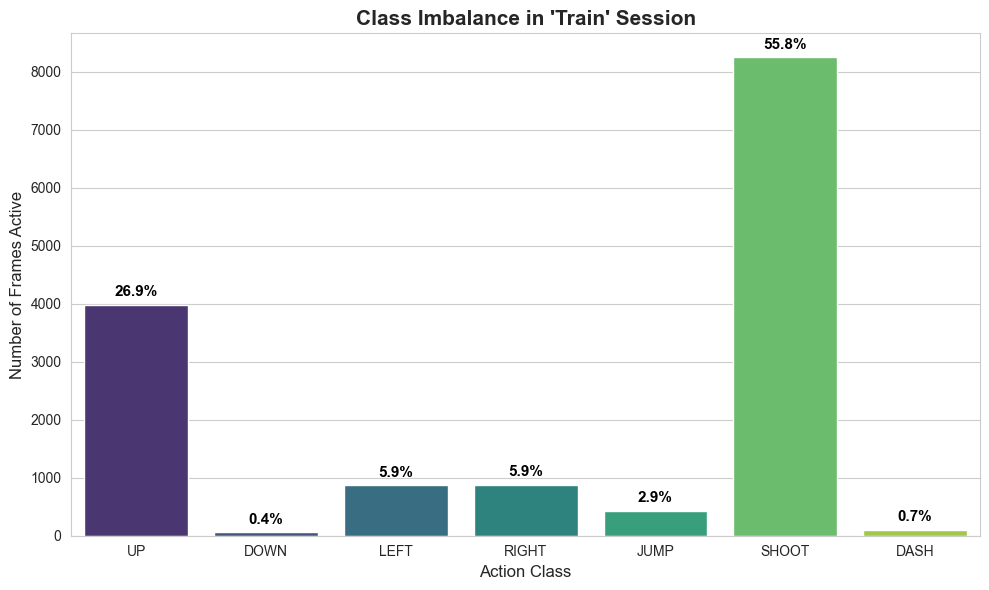

*Figure 1: Distribution of active frames per action class in the training session.*

Due to this distribution, a standard model optimizing for global accuracy can achieve $\approx 96\%$ accuracy simply by predicting "Shoot" constantly and never "Jumping." (refer to Appendix A's AE + LSTM model)

### **1.3 Methodology and Experimental Design**
To overcome this, I designed an experiment to evaluate the trade-offs between Latent Space size and RNN Cell type.

1. **Data Acquisition:** Utilized a custom **Session Recorder** (Appendix C) to gather dataset of 15 sessions of gameplay.
2. **Vision Layer:** An **Autoencoder** compresses raw frames ($128 \times 72$) into different sizes of Latent Vectors.
3. **Decision Layer:** Comparing **LSTM** (Long Short-Term Memory) vs. **GRU** (Gated Recurrent Unit)
*   Additionally, I Implemented **Sigmoid Focal Loss** to penalize the model heavily for missing rare events, forcing it to learn those events.

### **1.4 Key Findings**

1. The initial model (trained with standard Cross-Entropy) converged to a trivial solution—constantly shooting and never jumping or moving left/right—achieving high accuracy but 0% utility. Introducing Focal Loss ($\gamma=2.0$) immediately recovered reflexive behaviors, raising the Jump Recall from 0.00 to over 0.60.
2.  Performance did not scale linearly with model size. A latent dimension of **128** proved too compressed, blurring small projectiles and causing the agent to run into damage. Conversely, a dimension of **1024** led to overfitting. The **512 dimensions** balanced detail retention with generalization.
3.  Contrary to my initial hypothesis that the LSTM's complex gating would be superior, the **GRU architecture** outperformed the LSTM at the optimal latent dimension (512). The best model (GRU-512) achieved a **Composite F1-Score of 0.67**, successfully chaining jumps and arrow keys that the initial model completely ignored.

## **2. Data Collection and Pre-processing**

### **2.1 Data Collection**

#### Full code and code explanation in **Appendix C**

To capture this data, the recorder generates three distinct files for every session:
1.  **Video (`.mp4`):** The visual gameplay recorded at 10 FPS.
2.  **Event Log (`_events.jsonl`):** A stream of keystrokes (`keydown`/`keyup`), each tagged with a UTC timestamp.
3.  **Frame Log (`_frames.jsonl`):** This file records the UTC timestamp for every specific frame index in the `.mp4` file, which helps mapping visual states to log events with millisecond accuracy.

### Main Challenge for Recordings (Variable Frame Rate Drift)

A critical engineering challenge in screen recording for imitation learning is **Variable Frame Rate Drift**. Standard recording loops utilizing `time.sleep()` accumulate execution latency (e.g., OS hangs during heavy gameplay). Over a 15-minute session, this causes the video duration to shrink relative to the time of the keystroke logs, misaligning labels.

To resolve this, I synchronized the session recorder with UTC time . Instead of relying on relative sleep times, the recorder enforces a forced constant frame rate. The worker thread calculates exactly when the next frame should exist ($t_{next}$). If the system lags and $t_{now} > t_{next}$, the recorder duplicates the current frame to fill the missing time slots, ensuring the video file stays aligned with the UTC timestamps of the input logs.

### **2.2 Data Loading and Visual Transformation**
#### [GitHub - Training + Test Data (`.jsonl` logs)](https://github.com/ddanakim0304/CS156-Assignment-2/tree/main/data/sessions)

The raw input ($1280 \times 720$ RGB) is too high-dimensional for efficient training. The preprocessing pipeline transforms this into a tensor format suitable for the Autoencoder.

**Transformation Pipeline:**
1.  **Grayscale Conversion:** Reduces tensor depth ($3 \to 1$). Color is redundant for *Cuphead* mechanics (projectiles are distinct by shape/contrast).
2.  **Resizing:** Downsamples resolution to $128 \times 72$ to reduce dimensionality while preserving projectile visibility.
3.  **Normalization:** Scales pixel intensity from $[0, 255]$ to $[0, 1]$ for neural network stability.

**Code Snippet from model training code (Appendix A)**
```python
# Filter frames outside fight markers to reduce noise
if any(start <= t <= end for start, end in intervals):
    # Preprocessing: Resize -> Grayscale -> Normalize
    frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype('float32') / 255.0
    X_buffer.append(np.expand_dims(frame, axis=-1))
```

**Output Shape:**
After processing 15 sessions, the resulting dataset consists of **9,549 frames**.
```python
# Output from Data Loader (Appendix A)
Dataset Loaded. Train: (9549, 72, 128, 1)
Dataset Loaded. Val:   (590, 72, 128, 1)
```

### **2.3 Sequence Generation (Sliding Window)**
To allow the Recurrent Neural Network (RNN) to infer velocity and trajectory, individual frames must be structured into temporal sequences. I utilized a sliding window approach:

*   **Sequence Length ($T$):** 10 frames (1.0 second of context).
*   **Stride:** 1 frame.

For a given frame $f_t$, the model receives input vector $X_t = [f_{t-9}, f_{t-8}, ..., f_t]$.

(Further explanation in section 3.2)

### **2.4 Data Splitting Strategy**
I used session-based splitting rather than random shuffling. Random shuffling would leak information by placing adjacent frames (e.g., Frame 100 in Train, Frame 101 in Test) in different sets, allowing the model to "cheat" via interpolation.

*   **Training Set:** 15 win/loss mixed sessions (approx. 15 mins of gameplay).
*   **Validation Set:** 1 specific "Test Session". This session was recorded separately to capture a "Perfect Run" with minimized human error, providing a clean benchmark for evaluation.

## **3. Mathematical Underpinnings and Model Architecture**

The agent must solve two distinct mathematical problems: **State Abstraction** (What is on the screen?) and **Trajectory Inference** (Where is it going?). Finally, the optimization process must address the extreme class imbalance identified in EDA.

### **3.1 The Vision Layer - Autoencoder**
**The Problem**

The raw input $x_t$ is a $128 \times 72$ grayscale image. Treating this as a flat vector of 9,216 features is inefficient because it ignores the spatial topology of the game (e.g., that the pixels forming a "projectile" are clustered together).

**The Solution**

I implemented a **Autoencoder with convolutional layers** to map the high-dimensional raw frame $x_t$ to a low-dimensional latent vector $z_t \in \mathbb{R}^{512}$.
$$ z_t = E_\phi(x_t) $$

Here, $E_\phi$ represents the Encoder network. As shown in the code below, I use **MaxPooling** to progressively downsample the spatial dimensions while increasing the depth (feature channels). This forces the latent vector $z_t$ to discard high-frequency noise (like background stars) and retain only the semantic "Game State"—specifically, the coordinates of the player and the enemies.

**Implementation**

```python
def build_advanced_ae(latent_dim):
    inp = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.MaxPool2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(2, padding='same')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(2, padding='same')(x)

    flat = layers.Flatten()(x)
    z = layers.Dense(latent_dim, activation='relu', name='latent')(flat)

    # ... (Decoder logic)

    return models.Model(inp, out), models.Model(inp, z)
```

### **3.2 The Decision Layer - LSTM vs GRU**
**Input-Output Definition:**
Before analyzing the internal gates, we must define the mathematical domain of the agent's decision process:
*   **Input ($Z_t$):** The input is a sequence of **Latent Vectors** generated by the Autoencoder, not raw pixels. Specifically, it is a tensor of shape $(10, 512)$, representing the last 1.0 second of gameplay history.
*   **Output ($\hat{y}_t$):** The network outputs a probability vector $\hat{y}_t \in [0, 1]^7$, representing the likelihood of pressing each of the 7 keys (Jump, Shoot, Dash, Up, Down, Left, Right).

To predict the correct action $y_t$ at the current frame, the model must understand the temporal context of the scene. Specifically, it must infer the **velocity vector** of incoming projectiles based on the sequence of past latent states $Z = \{z_{t-9}, \dots, z_t\}$ as discussed in Section 2.3.

I evaluated two Recurrent Neural Network (RNN) architectures to perform this sequence modeling.

#### **1. Long Short-Term Memory (LSTM)**

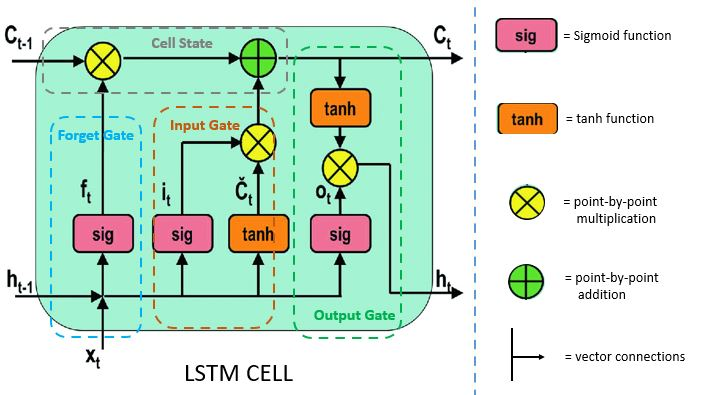

As illustrated in **Figure 2**, the LSTM architecture is defined by its **Cell State** ($C_t$, the top horizontal line). The cell is regulated by three distinct "gates" consisting of Sigmoid ($\sigma$) and Tanh neural network layers.

**Mathematical Formulation:**
In the equations below, $z_t$ represents our latent input vector (labeled as $x_t$ in Figure 2).

1.  **The Forget Gate ($f_t$ - Blue Box):** Decides what information to discard from the cell state. It looks at the previous hidden state $h_{t-1}$ and the current input $z_t$.
    $$ f_t = \sigma(W_f \cdot [h_{t-1}, z_t] + b_f) $$

2.  **The Input Gate ($i_t$ - Orange Box):** Decides what new information to store. A sigmoid layer ($i_t$) decides which values to update, while a tanh layer creates a vector of new candidate values ($\tilde{C}_t$).
    $$ i_t = \sigma(W_i \cdot [h_{t-1}, z_t] + b_i) $$
    $$ \tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, z_t] + b_C) $$

3.  **Cell State Update:** The old state $C_{t-1}$ is multiplied by $f_t$ (forgetting things), and the new candidate values are added.
    $$ C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t $$

4.  **The Output Gate ($o_t$ - Green Box):** Finally, the LSTM decides what to output ($h_t$) based on the filtered cell state.
    $$ o_t = \sigma(W_o \cdot [h_{t-1}, z_t] + b_o) $$
    $$ h_t = o_t \odot \tanh(C_t) $$

**Project Application:**
In the context of *Cuphead*, these gates perform specific roles in tracking game physics:
*   **Forget Gate ($f_t$):** Theoretically learns to "reset" memory when a threat is resolved. For example, if the latent vector $z_t$ indicates a projectile has exited the screen, $f_t \to 0$ for the neurons tracking that specific object's velocity.
*   **Output Gate ($o_t$):** This is crucial for the "Reflex" action. Even if the Cell State remembers a projectile exists ($C_t$), the Output Gate decides if it is *currently* dangerous enough to trigger a "Jump" command in the hidden state $h_t$.
*   **Why I tested this:** I hypothesized that this explicit separation of "Memory" ($C_t$) and "Action" ($h_t$) would allow the agent to track projectiles that are temporarily occluded or require delayed reactions.

#### **2. Gated Recurrent Unit (GRU)**
The GRU simplifies the LSTM by merging the Cell State and Hidden State into a single state $h_t$. It combines the Forget and Input gates into a single **Update Gate** ($z_t$).

**Mathematical Formulation:**
The Update Gate $z_t$ determines how much of the past information to pass along to the future:
$$ z_t = \sigma(W_z \cdot [h_{t-1}, z_t]) $$

The final hidden state $h_t$ is a linear interpolation between the previous state $h_{t-1}$ and the new candidate state $\tilde{h}_t$:
$$ h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t $$

**Performance Hypothesis**

I  hypothesized (and later confirmed in Section 4) that the GRU would outperform the LSTM for this specific project.
1.  To dodge a projectile, the agent only needs to track its position over the last $\approx 10$ frames (1 second). It does *not* need to remember actions taken 30 seconds ago.
2.  The GRU's equation $h_t = (1 - z_t) \odot h_{t-1} \dots$ naturally models a **moving average**. This is mathematically equivalent to calculating momentum or velocity, which is the exact feature required to detect if an enemy is moving *towards* or *away* from the player.
3.  The GRU removes the separate Cell State, reducing the parameter count by $\approx 25\%$. With a limited dataset of 15 sessions (approx. 9,500 samples), the LSTM's higher complexity led to overfitting (memorizing specific frame sequences). The GRU's simpler architecture forced it to generalize the physics of movement rather than memorizing the video.

### **3.3 Optimization - Focal Loss**
**The Limitation of Cross-Entropy**
In the initial experiment, the model converged to a suboptimal local minimum: holding the "Shoot" button and never moving. This occurred because the model was optimized using standard **Binary Cross-Entropy (BCE)**:

$$ BCE(p_t) = -\log(p_t) $$

Since "Shoot" actions constitute most of the data, the cumulative loss is dominated by the majority class. The optimizer reduces global loss most efficiently by perfecting the "Shoot" prediction and ignoring the other keys' errors, as they contribute negligibly to the total cost.

**The Solution: Sigmoid Focal Loss**
To force the model to learn rare behaviors, I implemented **Focal Loss**. This adds a modulating factor $(1 - p_t)^\gamma$ to the BCE equation:

$$ FL(p_t) = -\alpha (1 - p_t)^\gamma \log(p_t) $$

*   **$p_t$:** The model's predicted probability for the true class.
*   **$\gamma$ (Gamma):** The focusing parameter (set to 2.0).

**Mechanism of Action:**
1.  **Easy Examples (Shooting):** If the model is 90% confident it should shoot ($p_t=0.9$), the modulating factor becomes $(1 - 0.9)^2 = 0.01$. The loss contribution is effectively silenced.
2.  **Hard Examples (Jumping):** If the model misses a jump ($p_t=0.2$), the factor becomes $(1 - 0.2)^2 = 0.64$. The loss remains high.

This mathematical modification reshapes the gradient landscape, forcing the optimizer to focus exclusively on the "hard" minority classes (Jumps/Dashes) rather than the easy majority class.

## **4. Results and Discussion**

### **4.1 Initial Model Evaluation (Majority Class Bias)**
The initial architecture (Autoencoder + LSTM) trained with standard Binary Cross-Entropy loss achieved a global binary accuracy of **97.31%** (from the training session's output - Appendix A). However, a granular analysis of class-wise performance reveals that the model converged to a **trivial solution**.

The high accuracy metric is misleading. In the training dataset, the 'Jump' action is inactive (0) for 97.1% of frames. Consequently, a model that learns a deterministic policy of *never jumping* will automatically achieve 97.1% accuracy on that specific class. The 97.31% global accuracy reflects the model's success in predicting the "OFF" state for minority classes, rather than its ability to play the game.

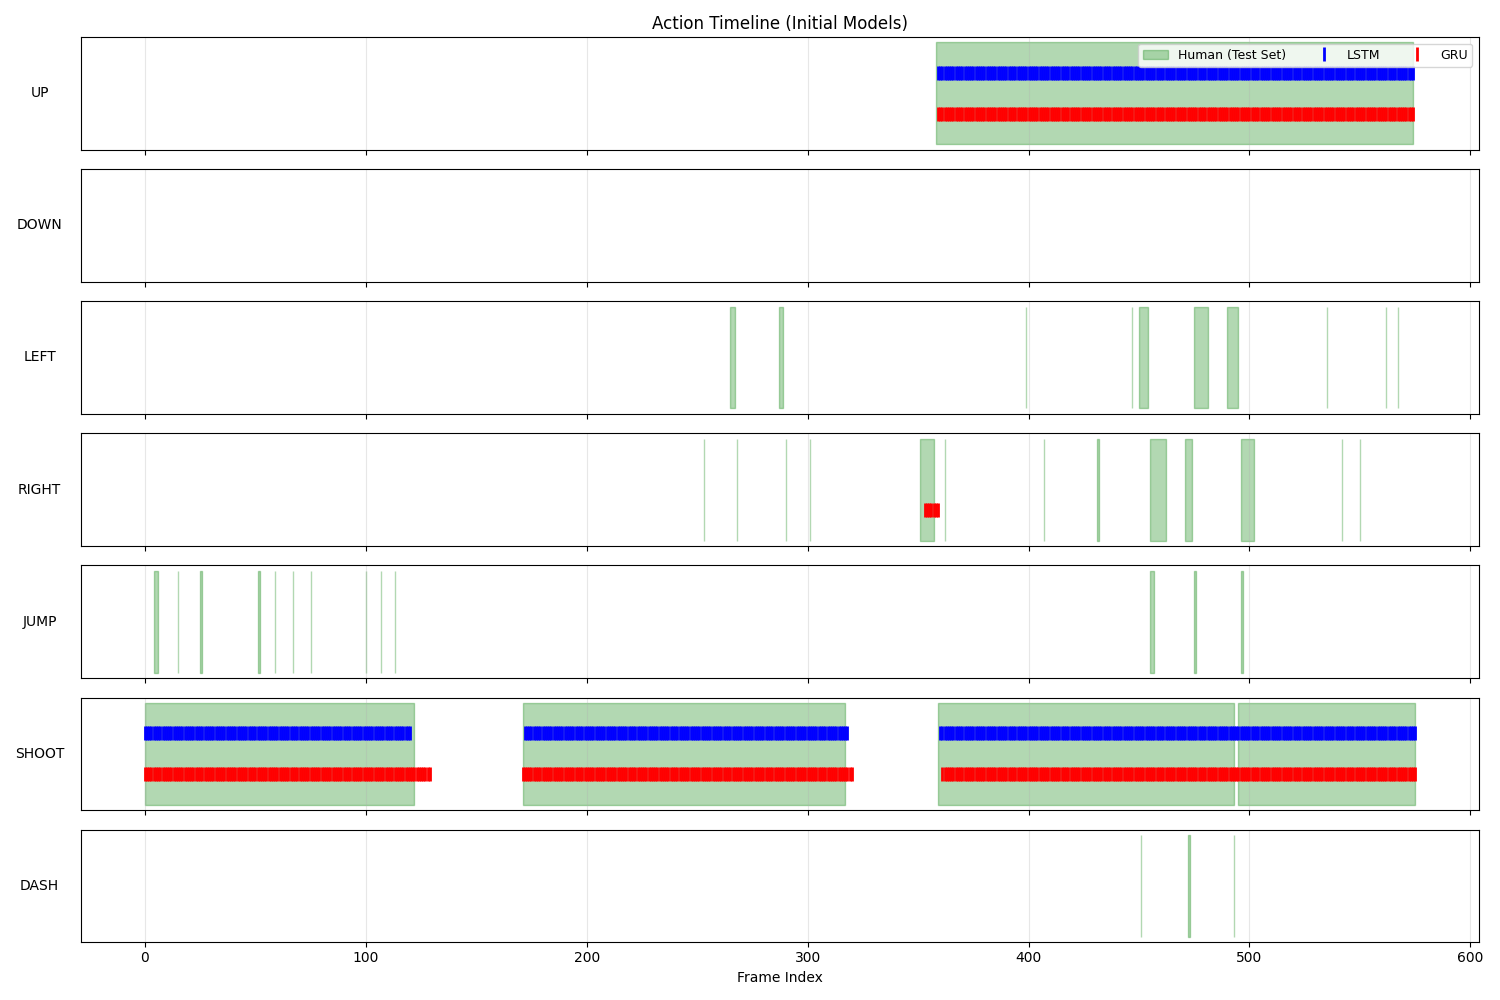
*Figure 3: Prediction timeline of human input vs. the initial model. The absence of activation in the JUMP, DASH, LEFT rows indicates a failure to learn minority class behaviors.*

As illustrated in **Figure 3**, the model exhibits severe **Majority Class Bias**. The AI predictions (Blue/Red lines) are flat for dynamic actions like 'Jump' and 'Dash', completely ignoring the human input (Green blocks).

**Heatmap Analysis (Figure 4):**
The quantitative breakdown in **Figure 4** confirms this behavioral failure. The F1-Scores for 'Jump', 'Dash', and 'Left' are **0.00**. The model completely suppressed these actions to minimize the penalty of False Positives. 
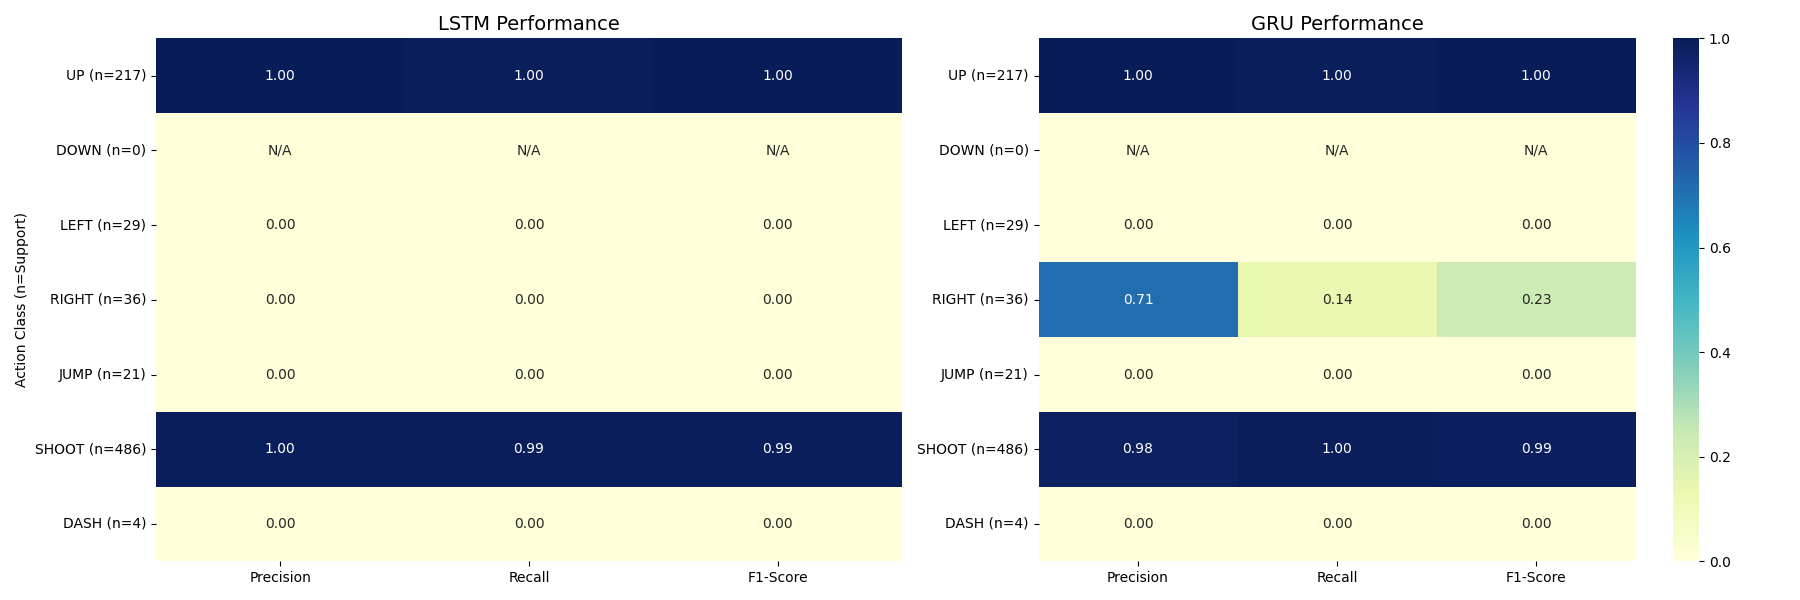
*Figure 4: Evaluation metrics heatmap (LSTM vs. GRU). Note the 0.00 scores for defensive mechanics.*

Interestingly, the model achieved perfect performance on 'Up' (F1=1.00) and 'Shoot' (F1=0.99). This indicates the model successfully learned **State-based actions** (holding a button for long durations based on the environment) but failed to learn **Reflex-based actions** (split-second reactions to movement).

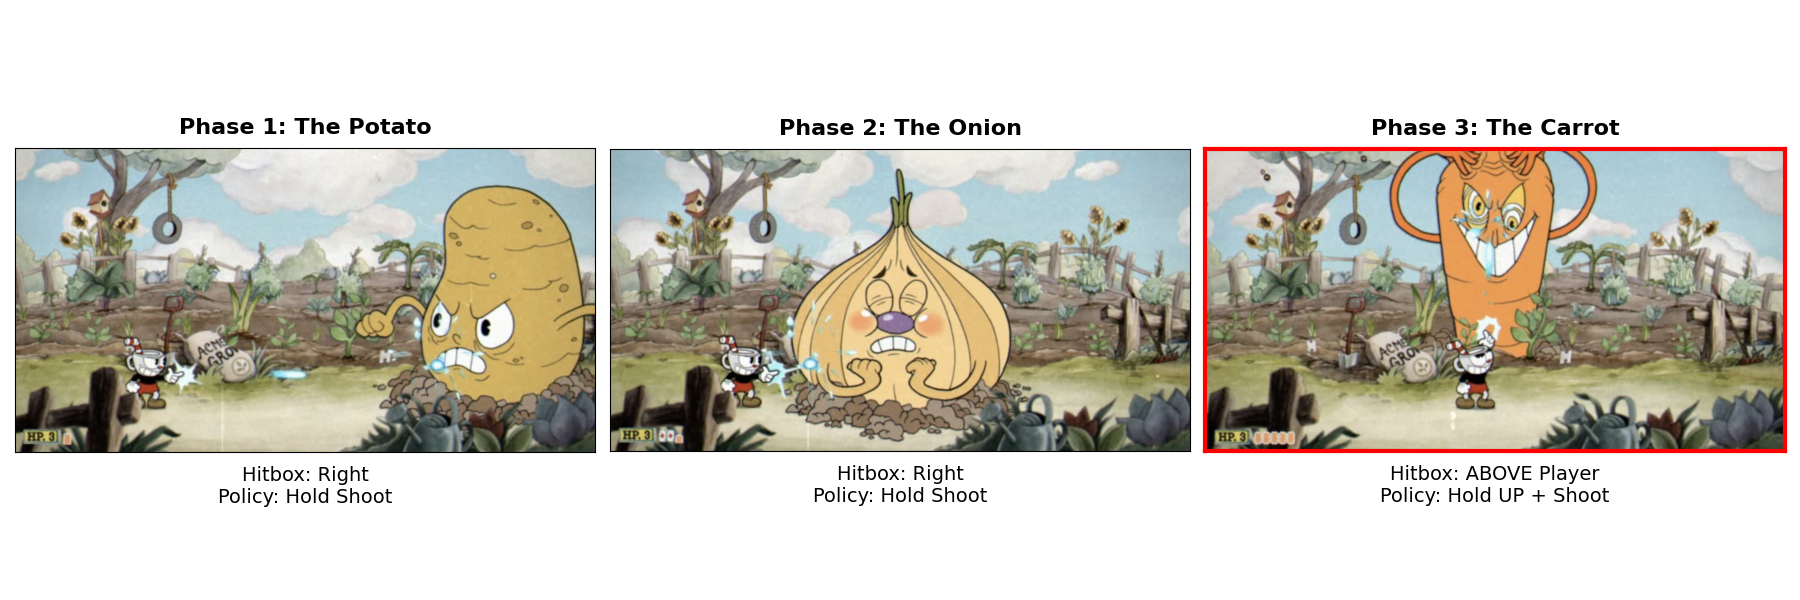
*Figure 5: Visual analysis of boss phases. The 'Up' action is semantically tied to the distinct visual features of Phase 3.*

As shown in **Figure 5**, the **'Up' key** is strictly correlated with **Phase 3 (The Carrot)**, where the enemy hitbox shifts from the right side to the top of the screen. The Autoencoder successfully learned to distinguish the semantic visual features of the "Carrot" from the "Potato" and "Onion," allowing the RNN to map this static visual state to the sustained action of holding 'Up'. Conversely, 'Jump' is a dynamic response to transient projectiles (velocity inference), which the baseline model ignored due to the overwhelming gradient from the majority class.


This confirms that standard accuracy is an invalid metric for imitation learning in sparse-event environments, necessitating the use of Focal Loss and F1-based evaluation.


### **4.2 Hyperparameter Optimization and Architecture Search**
To rectify the class imbalance, I introduced **Sigmoid Focal Loss** ($\gamma=2.0$) to penalize the model for misclassifying rare events. Subsequently, I conducted a grid search across two key hyperparameters: Latent Space Dimensions $[128, 256, 512, 1024]$ and recurrent Cell Type: $[LSTM, GRU]$.

The heatmap below compares the **Composite F1-Score** (the unweighted mean of Jump, Dash, and Shoot F1 scores) across all 8 configurations.

![All_Models_Heatmap.png](attachment:All_Models_Heatmap.png)
*Figure 4: Comparative performance of model architectures. The GRU-512 configuration (Row 6) achieves the highest composite score.*

**Analysis of Results:**
1.  **Latent Representation Capacity:**
    *   **128 Dimensions:** Performance was suboptimal (Composite Score $\approx 0.43$). The reconstruction loss suggests that 128 dimensions provided insufficient information density to preserve small, high-frequency features (e.g., small projectiles), rendering them invisible to the decision layer.
    *   **512 Dimensions:** This capacity yielded the highest performance, suggesting it is the optimal manifold size for capturing the relevant game state without encoding excessive noise.
    *   **1024 Dimensions:** Performance degraded ($\approx 0.50$). This indicates **overfitting**, where the model likely encoded background artifacts or noise rather than generalizable physics.

2.  **Temporal Dynamics (GRU vs. LSTM):**
    *   At the optimal latent dimension (512), the **GRU outperformed the LSTM** (Score 0.67 vs 0.55).
    *   This supports the hypothesis that the GRU's simplified update gate is more efficient at modeling the short-term velocity inference required for this task, whereas the LSTM's higher parameter count likely led to overfitting on the limited dataset (15 sessions).

### **4.3 Optimal Model Performance: GRU (Latent 512)**
The final selected architecture was the **GRU with 512 Latent Dimensions**, trained with Focal Loss.

![Best_Model_Timeline.png](attachment:Best_Model_Timeline.png)
*Figure 5: Temporal prediction analysis of the Best Model. The AI predictions (Red) show strong alignment with Human Ground Truth (Green) for minority classes.*

**Quantitative Improvements:**
*   **JUMP F1:** Increased from **0.00 $\to$ 0.62**. The agent successfully learned the visual triggers for defensive maneuvers.
*   **SHOOT F1:** Maintained at **0.99**, indicating no degradation in majority class performance.
*   **DASH F1:** Improved to **0.40**. While recall remains lower than 'Jump', the model demonstrates non-zero capability in executing complex evasion.

### **4.4 Qualitative Analysis: Behavioral Cloning Verification**
To validate the model's utility beyond static metrics, I generated a side-by-side video comparison overlaying the AI's predicted actions onto the test session gameplay.

**Observations:**
*   **Temporal Alignment:** The model's reaction latency is minimal. Predicted actions (Red indicators) typically align with human inputs (Green indicators) within a 100ms window, demonstrating that the RNN successfully inferred the velocity of incoming threats.
*   **Phase Recognition:** The model correctly identified the transition to Phase 3 ("Mega Carrot"). In this phase, the human player switches from horizontal movement to vertical tracking (holding 'Up' + 'Shoot'). The model successfully replicated this behavioral shift, confirming that the Autoencoder learned to distinguish semantically distinct boss phases.
*   **Oscillation Artifacts:** The model occasionally exhibits rapid oscillation between 'Left' and 'Right' inputs during idle periods. This is a known phenomenon in behavioral cloning (Causal Confusion), where the model struggles to disambiguate state transitions when the optimal policy is ambiguous.

# References

Singhal, G. (2020, September 9). Introduction to LSTM units in RNN [Diagram]. Pluralsight. https://www.pluralsight.com/resources/blog/guides/introduction-to-lstm-units-in-rnn

https://blog.keras.io/building-autoencoders-in-keras.html

https://www.youtube.com/watch?v=YCzL96nL7j0&t=594s

https://www.youtube.com/watch?v=qiUEgSCyY5o

https://www.youtube.com/watch?v=wipq--gdIGM&feature=youtu.be

# Appendix B: EDA

Loading events from Train_events.jsonl...
Loading frames from Train_frames.jsonl...

DATASET BALANCE ANALYSIS: Train
Total Frames Analyzed: 14791
----------------------------------------
Action  Frame_Count Percentage
 SHOOT         8254     55.80%
    UP         3980     26.91%
 RIGHT          875      5.92%
  LEFT          869      5.88%
  JUMP          434      2.93%
  DASH          105      0.71%
  DOWN           60      0.41%
----------------------------------------


/var/folders/_2/1tb09tx55zx8v2lc5wd2_8400000gn/T/ipykernel_78855/1660731870.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Action', y='Frame_Count', data=df, order=ACTION_ORDER, palette='viridis')


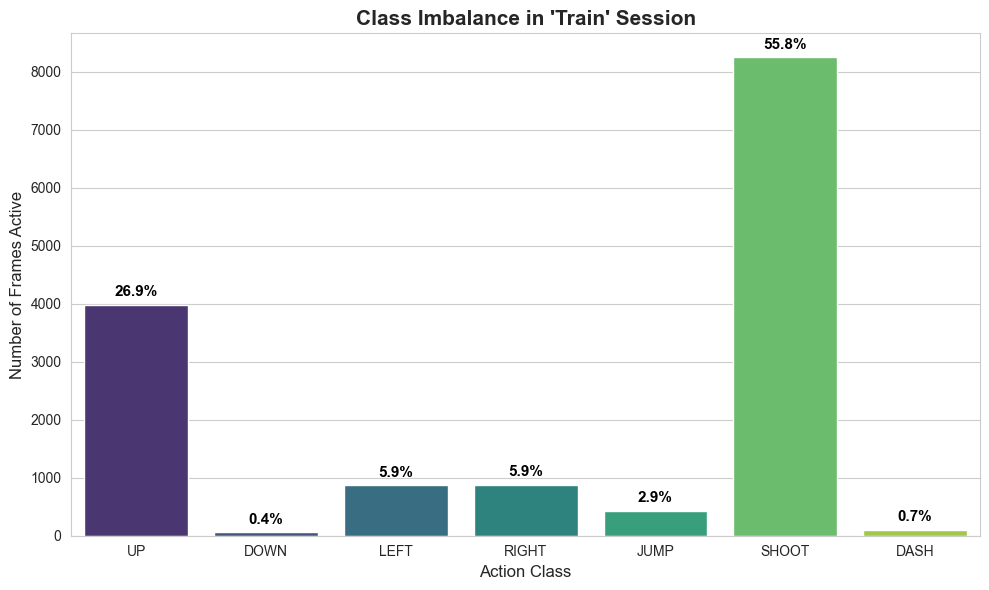

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA_DIR = Path("../data/sessions") 
SESSION_NAME = "Train"

# Key Mappings
KEY_MAP = {
    'Key.up': 'UP', 'Key.down': 'DOWN', 'Key.left': 'LEFT', 'Key.right': 'RIGHT', 
    'Key.space': 'JUMP', 'f': 'SHOOT', 'd': 'DASH'
}
ACTION_ORDER = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'JUMP', 'SHOOT', 'DASH']

def analyze_keystroke_balance():
    # 1. Define Paths
    event_path = DATA_DIR / f"{SESSION_NAME}_events.jsonl"
    frame_path = DATA_DIR / f"{SESSION_NAME}_frames.jsonl"

    # 2. Load Events (Key Presses)
    print(f"Loading events from {event_path.name}...")
    events = []
    with open(event_path, 'r') as f:
        for line in f:
            try:
                d = json.loads(line)
                if d.get('event') in ['keydown', 'keyup']:
                    k = d.get('key').strip("'").strip('"')
                    if k in KEY_MAP: 
                        events.append((d['t'], k, d['event']))
            except: continue
    events.sort(key=lambda x: x[0]) # Sort by time

    # 3. Load Frame Timestamps
    print(f"Loading frames from {frame_path.name}...")
    with open(frame_path, 'r') as f:
        frame_timestamps = [json.loads(line)['t'] for line in f]

    # 4. Replay History to Count Active Frames
    # We iterate through frames and update key state incrementally
    active_keys = set()
    event_idx = 0
    num_events = len(events)
    
    # Dictionary to store how many frames each action was active
    action_counts = {action: 0 for action in ACTION_ORDER}
    total_frames = 0
    
    for t in frame_timestamps:
        # Update key state up to current frame time
        while event_idx < num_events and events[event_idx][0] <= t:
            _, key, etype = events[event_idx]
            if etype == 'keydown':
                active_keys.add(key)
            elif etype == 'keyup':
                active_keys.discard(key)
            event_idx += 1
            
        # Record state for this frame
        for k in active_keys:
            if k in KEY_MAP:
                action_name = KEY_MAP[k]
                action_counts[action_name] += 1
        
        total_frames += 1

    # 5. Process Statistics
    df = pd.DataFrame(list(action_counts.items()), columns=['Action', 'Frame_Count'])
    df['Percentage'] = (df['Frame_Count'] / total_frames) * 100

    # Print Stats Table
    print("\n" + "="*40)
    print(f"DATASET BALANCE ANALYSIS: {SESSION_NAME}")
    print("="*40)
    print(f"Total Frames Analyzed: {total_frames}")
    print("-" * 40)
    print(df.sort_values(by='Frame_Count', ascending=False).to_string(index=False, formatters={'Percentage': '{:.2f}%'.format}))
    print("-" * 40)

    # 6. Visualization
    plt.figure(figsize=(10, 6))
    
    # Create Bar Plot
    sns.set_style("whitegrid")
    ax = sns.barplot(x='Action', y='Frame_Count', data=df, order=ACTION_ORDER, palette='viridis')
    
    # Add Titles
    plt.title(f"Class Imbalance in '{SESSION_NAME}' Session", fontsize=15, fontweight='bold')
    plt.ylabel("Number of Frames Active", fontsize=12)
    plt.xlabel("Action Class", fontsize=12)
    
    # Add Percentage Labels on top of bars
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        # Find the percentage for the current bar
        pct = df[df['Action'] == ACTION_ORDER[i]]['Percentage'].values[0]
        ax.text(p.get_x() + p.get_width() / 2., height + (total_frames * 0.01),
                f'{pct:.1f}%', ha="center", fontsize=11, fontweight='bold', color='black')

    plt.tight_layout()
    plt.show()


# Run the analysis
analyze_keystroke_balance()

## Appendix C: Custom Session Recorder Code

To ensure data integrity, I developed a custom Python application utilizing `tkinter` for the GUI, `mss` for high-speed screen capture, and `pynput` for non-blocking keyboard hooks.

[Full Source Code Repository](https://github.com/ddanakim0304/CS156-Assignment-2/tree/main/app)

**Directory Structure:**
```text
└── ddanakim0304-cs156-assignment-2/
    └── app/
        ├── session_recorder.py    # Core Sync Logic & Video IO
        ├── keyboard_listener.py   # Global key hooks
        └── main.py                # UI Entry Point & Threading
```

### **C.1 Core Synchronization Logic (`session_recorder.py`)**
This module addresses the **Variable Frame Rate (VFR) Drift** problem described in Section 2.1.

**The Algorithm: Forced Constant Frame Rate**
Standard screen recording loops often use `time.sleep(1/fps)`. However, system latency ($\delta$) accumulates with every frame ($t_{sleep} + \delta$), causing the video to desynchronize from the wall-clock timestamps of the logs.

My solution:
1.  Calculate the exact UTC timestamp where the next frame *should* be (`next_frame_time`).
2.  Capture a frame.
3.  Compare `next_frame_time` to `time.time()` (current system time).
4.  **If the system is lagging** (Current Time > Next Frame Time), the loop writes the **same frame multiple times** to the video file and logs the specific timestamp for each duplicate. This ensures the video file duration matches real-time perfectly, even if the game stutters.

**Relevant Code Snippet:**
```python
with mss.mss() as sct:
    target_fps = 10.0
    frame_duration = 1.0 / target_fps
    
    # Schedule based on absolute UTC time
    next_frame_time = time.time()

    while not self._shutdown_event.is_set():
        # 1. Capture Frame
        try:
            img = sct.grab(self.region)
            img_np = np.array(img)
            frame_bgr = cv2.cvtColor(img_np, cv2.COLOR_BGRA2BGR)
        except Exception as e:
            print(f"Capture error: {e}")
            continue

        # 2. Sync Logic
        now = time.time()
        
        while next_frame_time < now:
            # Write video frame
            self._video_writer.write(frame_bgr)
            
            # RECORD EXACT MAPPING: Frame -> UTC Time
            frame_entry = {"t": next_frame_time}
            self._frame_file.write(json.dumps(frame_entry) + '\n')
            
            # Advance schedule
            next_frame_time += frame_duration
        
        # 3. Sleep
        # Only sleep if we are ahead of schedule
        time_to_sleep = next_frame_time - time.time()
        if time_to_sleep > 0:
            time.sleep(time_to_sleep)
```

### **C.2 Global Input Handling (`keyboard_listener.py`)**
This module uses `pynput` to hook keyboard events at the OS level, allowing the recorder to capture inputs even when the *Cuphead* window has focus.

**Key Logic:**
1. Converts platform-specific key codes (e.g., `Key.space`) into standardized string labels.
2. Maintains a set of `_pressed_keys` to prevent "key repeat" noise (holding a key down generating multiple events).
3. Implements a safety mechanism to pause listening while the user types the session name in the UI, preventing those keystrokes from leaking into the game logs.

### **C.3 UI and Thread Safety (`main.py`)**
The application runs the UI on the main thread (`tkinter`) and the recording logic on a separate background thread. To prevent race conditions or UI freezing, I implemented a **Message Queue** architecture.

**The Architecture:**
1.  Detects a hotkey (e.g., '1' to Stop). Puts a message into `ui_action_queue`.
2.  Polls the queue every 100ms. If a message is found, it updates the button state and triggers the `SessionRecorder`.